<a href="https://colab.research.google.com/github/afesl007/Image-Classifier-using-a-Convolutonal-Network-/blob/master/cifar10_cnn_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks
---
In this notebook, I train a **CNN** to classify images from the CIFAR-10 database.

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.


### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)



In [0]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


---
## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)



In [0]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

0it [00:00, ?it/s]

100%|█████████▉| 170254336/170498071 [00:17<00:00, 14686272.85it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### Visualize a Batch of Training Data

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

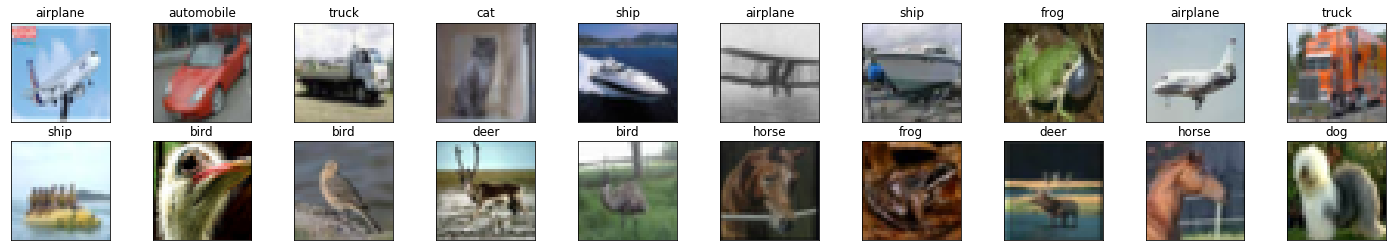

In [0]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail



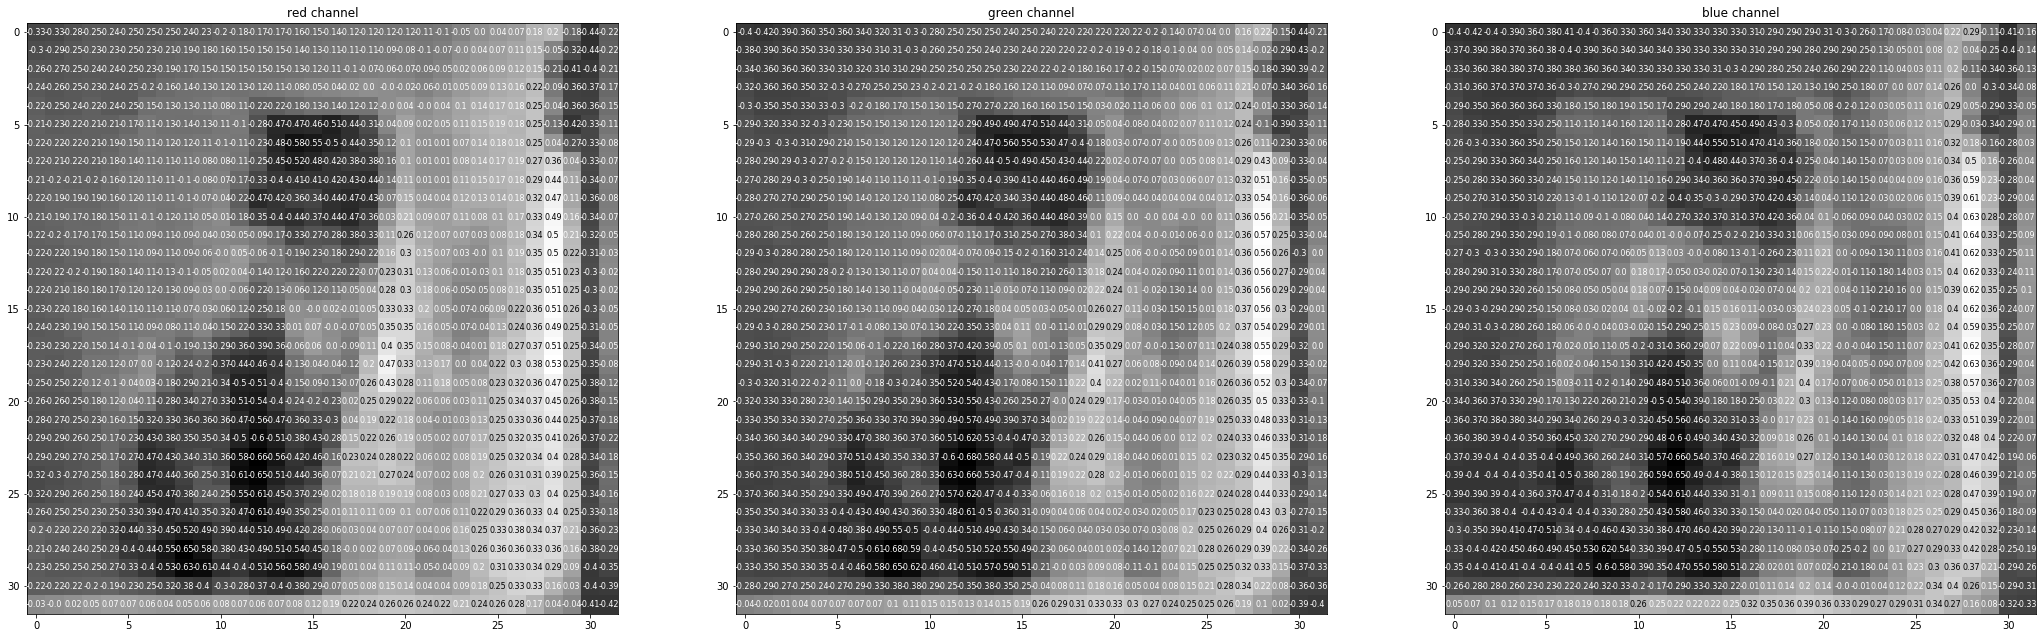

In [0]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)



#### Output volume for a convolutional layer



In [0]:
torch.hub.list('rwightman/pytorch-dpn-pretrained')
model = torch.hub.load('rwightman/pytorch-dpn-pretrained', 'dpn68', pretrained=True)

Downloading: "https://github.com/rwightman/pytorch-dpn-pretrained/archive/master.zip" to /root/.cache/torch/hub/master.zip
Using cache found in /root/.cache/torch/hub/rwightman_pytorch-dpn-pretrained_master
Downloading: "https://github.com/rwightman/pytorch-dpn-pretrained/releases/download/v0.1/dpn68-66bebafa7.pth" to /root/.cache/torch/checkpoints/dpn68-66bebafa7.pth
100%|██████████| 48.4M/48.4M [00:00<00:00, 121MB/s] 


In [0]:
print(model)

DPN(
  (features): Sequential(
    (conv1_1): InputBlock(
      (conv): Conv2d(3, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(10, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (conv2_1): DualPathBlock(
      (c1x1_w_s1): BnActConv2d(
        (bn): BatchNorm2d(10, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
        (conv): Conv2d(10, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (c1x1_a): BnActConv2d(
        (bn): BatchNorm2d(10, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
        (conv): Conv2d(10, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (c3x3_b): BnActConv2d(
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_

In [0]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # max pooling layer
       
        
        self.conv2 = nn.Conv2d(16,32,3,padding=1)
        
        self.conv3 = nn.Conv2d(32,64,3,padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(64 * 4 * 4,  512)
        self.fc2 = nn.Linear(512,10)
        
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 *4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()


Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)



In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
import torch.optim as optim


# specify loss function
criterion = nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)


---
## Train the Network



In [0]:
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(n_epochs):
    
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    
    for data, label in train_loader:
        if train_on_gpu:
            data, label = data.cuda(), label.cuda()
        
        optimizer.zero_grad()
        
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*data.size(0)
        
    model.eval()
    for data, label in valid_loader:
        if(train_on_gpu):
            data, label = data.cuda(), label.cuda()
        
        output = model(data)
        loss = criterion(output, label)
        valid_loss += loss.item() * data.size(0)
        
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    
    
    
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 0 	Training Loss: 1.638800 	Validation Loss: 1.244489
Validation loss decreased (inf --> 1.244489).  Saving model ...
Epoch: 1 	Training Loss: 1.221539 	Validation Loss: 1.092184
Validation loss decreased (1.244489 --> 1.092184).  Saving model ...
Epoch: 2 	Training Loss: 1.081776 	Validation Loss: 1.044406
Validation loss decreased (1.092184 --> 1.044406).  Saving model ...
Epoch: 3 	Training Loss: 0.990741 	Validation Loss: 0.972013
Validation loss decreased (1.044406 --> 0.972013).  Saving model ...
Epoch: 4 	Training Loss: 0.921098 	Validation Loss: 0.921288
Validation loss decreased (0.972013 --> 0.921288).  Saving model ...
Epoch: 5 	Training Loss: 0.868429 	Validation Loss: 0.843200
Validation loss decreased (0.921288 --> 0.843200).  Saving model ...
Epoch: 6 	Training Loss: 0.839176 	Validation Loss: 0.852632
Epoch: 7 	Training Loss: 0.803865 	Validation Loss: 0.871196
Epoch: 8 	Training Loss: 0.782946 	Validation Loss: 0.845722
Epoch: 9 	Training Loss: 0.759842 	Validat

###  Load the Model with the Lowest Validation Loss

In [0]:
model.load_state_dict(torch.load('model_cifar.pt'))

FileNotFoundError: ignored

---
## Test the Trained Network



In [0]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
  
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

NameError: ignored

### Visualize Sample Test Results

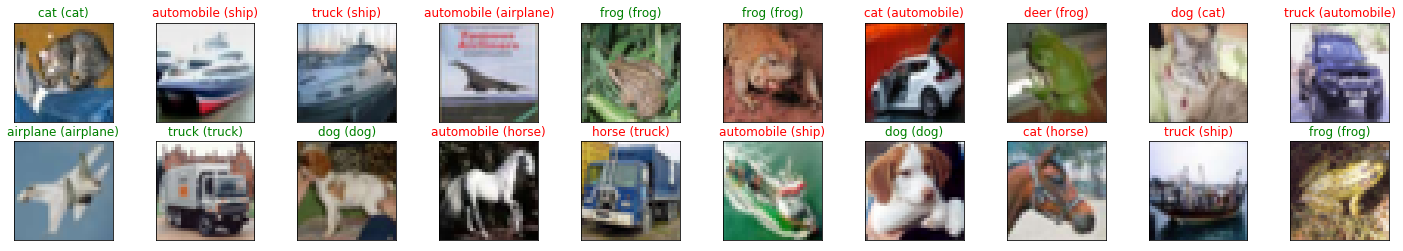

In [0]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))